In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from plotnine import ggplot, geom_line, facet_wrap, aes, scale_fill_gradient2, theme, labs, geom_point, scale_color_manual, \
geom_text, scale_fill_gradient2, theme_minimal, geom_boxplot, geom_tile, scale_x_discrete,element_text,scale_y_discrete
from pandas.api.types import CategoricalDtype

from ydata_profiling import ProfileReport

In [4]:
pd.set_option('display.max_rows', 100)

df = pd.read_csv('../data/ground_station_clean.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.head()

,Timestamp,Longitude,Latitude,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Soil_Moisture,Soil_Temperature,Wind_Dir_Sin,Wind_Dir_Cos
0,2024-06-01 00:00:00,-119.591264,49.886552,22.742917,45.541667,0.0,1.692917,9459.333333,18.383750,0.098017,-0.995185
1,2024-06-01 01:00:00,-119.591264,49.886552,20.600417,51.254167,0.0,1.870000,9412.666667,16.700833,-0.617379,-0.786666
2,2024-06-01 02:00:00,-119.591264,49.886552,16.647500,63.191667,0.0,1.901250,9393.333333,14.904167,0.333121,-0.942884
3,2024-06-01 03:00:00,-119.591264,49.886552,14.405833,67.770833,0.0,1.367083,9385.333333,12.776250,0.871428,-0.490524
4,2024-06-01 04:00:00,-119.591264,49.886552,12.257917,74.387500,0.0,1.441250,9348.000000,10.842083,-0.786666,-0.617379


In [5]:
print(df.isna().sum())

Timestamp           0
Longitude           0
Latitude            0
Temperature         0
Humidity            0
Precipitation       0
Wind_Speed_kmh      0
Soil_Moisture       0
Soil_Temperature    0
Wind_Dir_Sin        0
Wind_Dir_Cos        0
dtype: int64


In [11]:
def get_season(date):
    return ['Winter', 'Spring', 'Summer', 'Autumn'][(date.month % 12) // 3]
df['Season'] = df['Timestamp'].apply(get_season)
df.head()

,Timestamp,Longitude,Latitude,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Soil_Moisture,Soil_Temperature,Wind_Dir_Sin,Wind_Dir_Cos,Season
0,2024-06-01 00:00:00,-119.591264,49.886552,22.742917,45.541667,0.0,1.692917,9459.333333,18.383750,0.098017,-0.995185,Summer
1,2024-06-01 01:00:00,-119.591264,49.886552,20.600417,51.254167,0.0,1.870000,9412.666667,16.700833,-0.617379,-0.786666,Summer
2,2024-06-01 02:00:00,-119.591264,49.886552,16.647500,63.191667,0.0,1.901250,9393.333333,14.904167,0.333121,-0.942884,Summer
3,2024-06-01 03:00:00,-119.591264,49.886552,14.405833,67.770833,0.0,1.367083,9385.333333,12.776250,0.871428,-0.490524,Summer
4,2024-06-01 04:00:00,-119.591264,49.886552,12.257917,74.387500,0.0,1.441250,9348.000000,10.842083,-0.786666,-0.617379,Summer


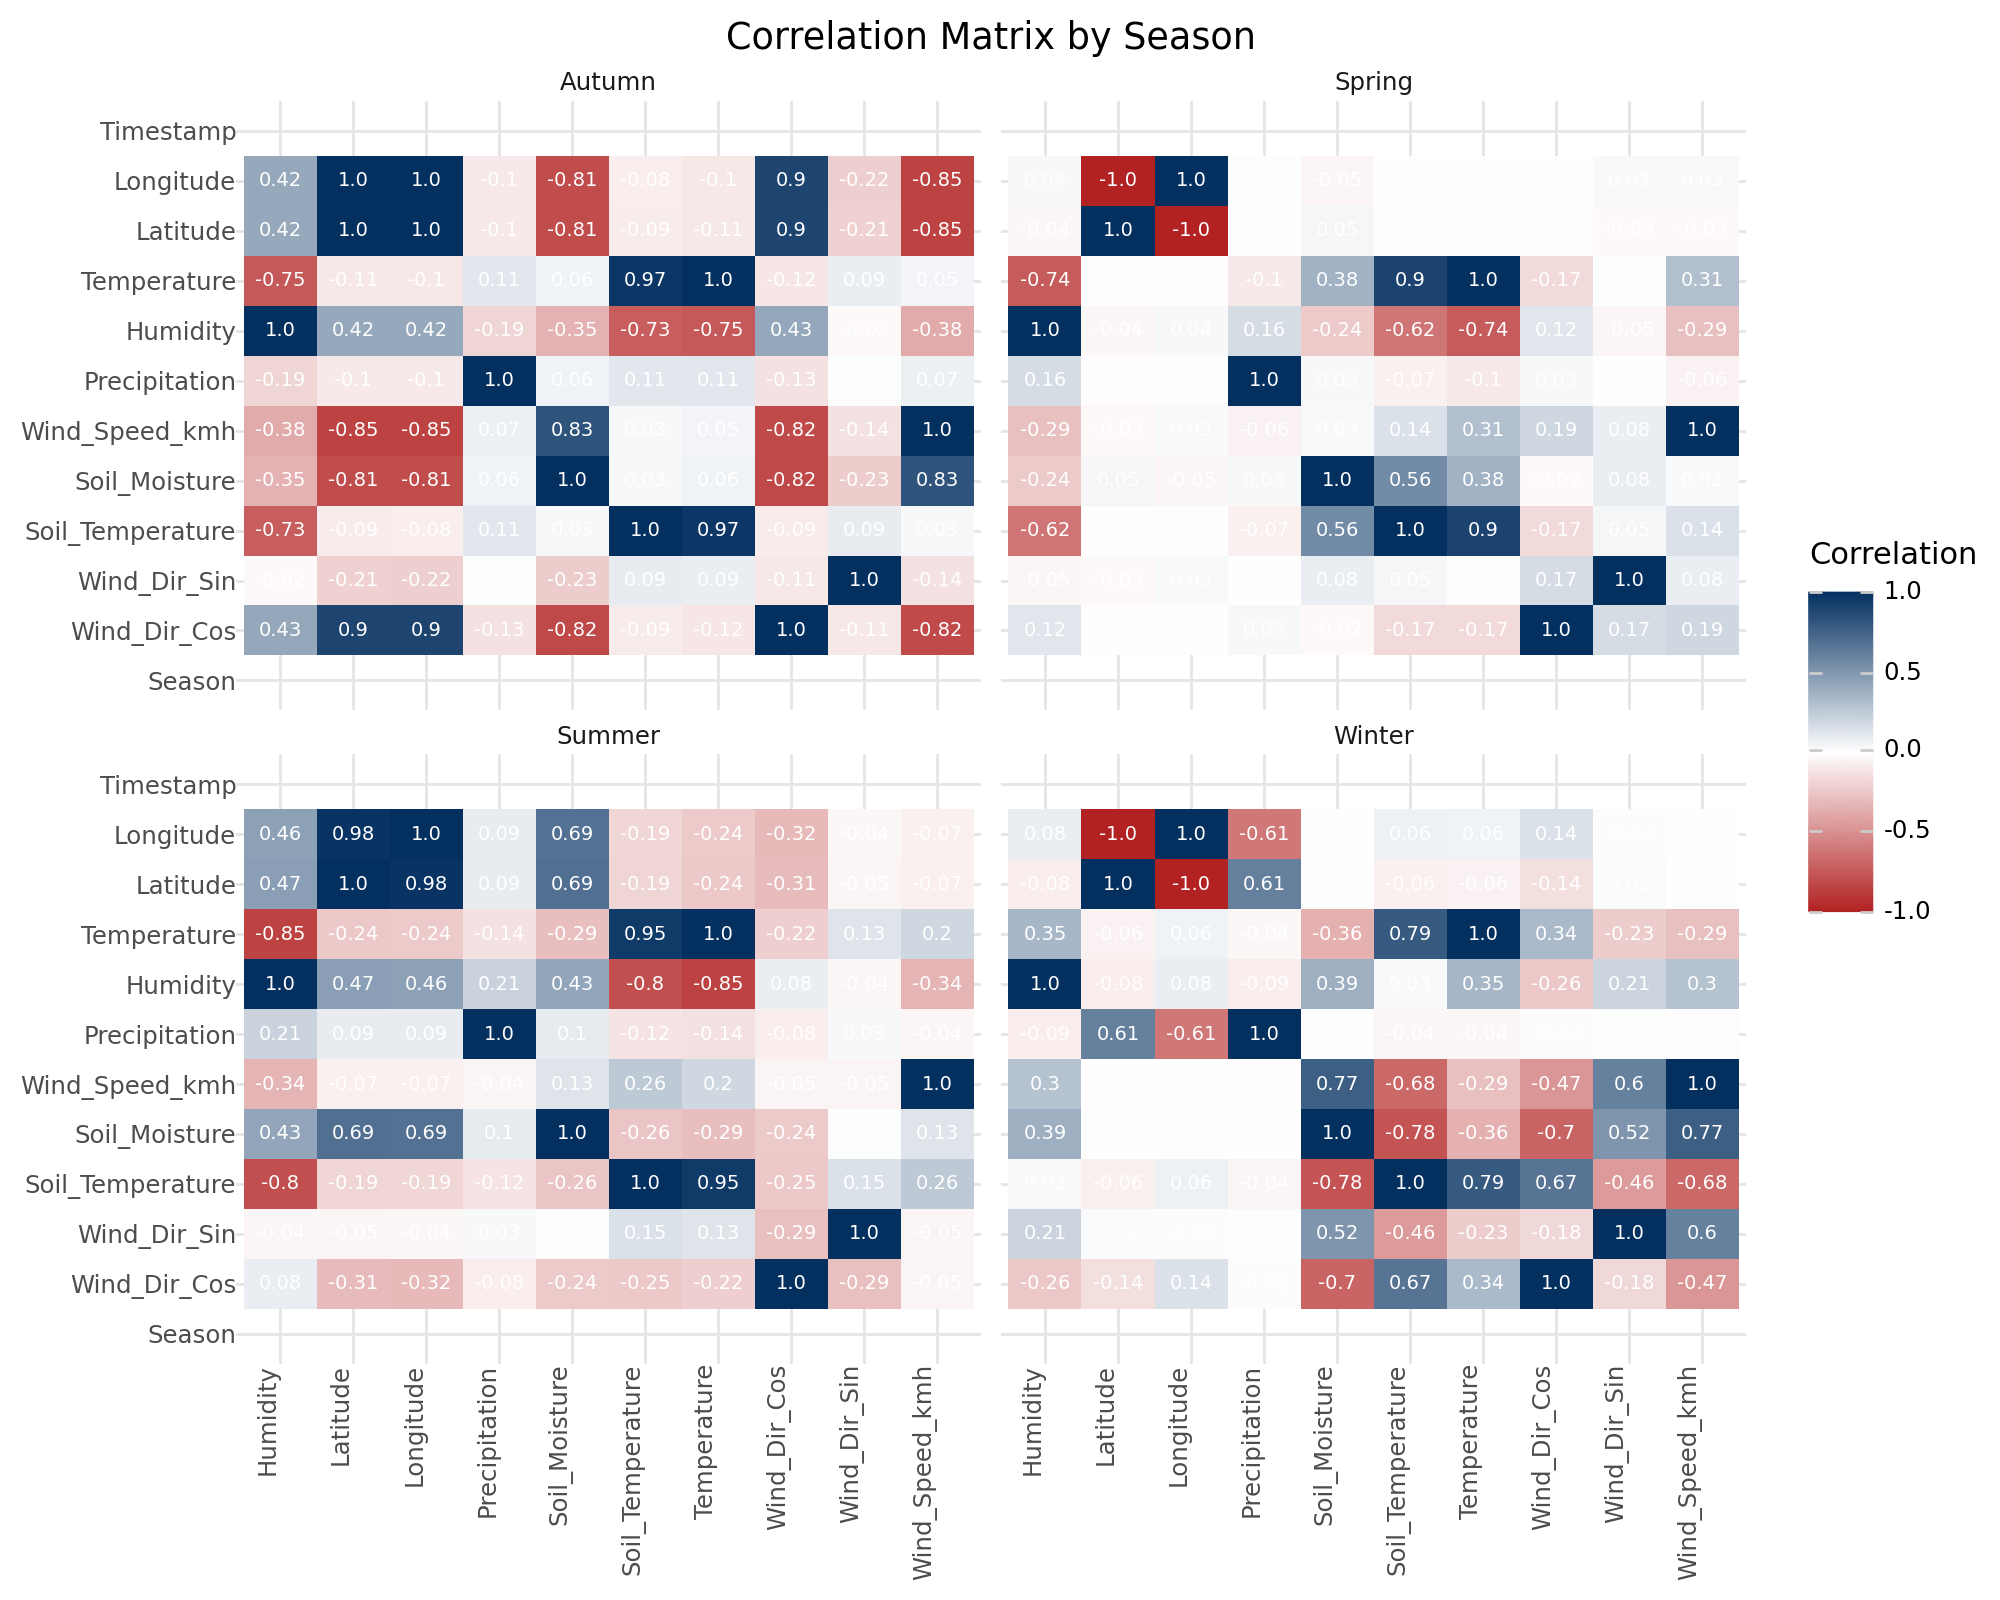

In [12]:
# Create an empty list to store long-form correlation data per season
season_corrs = []

# Loop through each season to calculate correlations
for season, group in df.groupby('Season'):
    numeric_group = group.select_dtypes(include='number')
    corr = numeric_group.corr().reset_index().melt(id_vars='index')
    corr.columns = ['Variable1', 'Variable2', 'Correlation']
    corr['Season'] = season
    season_corrs.append(corr)

# Combine all into a single DataFrame
corr_long = pd.concat(season_corrs)


# Plot with facet for each season
plot = (
    ggplot(corr_long, aes(x='Variable1', y='Variable2', fill='Correlation')) +
    geom_tile() +
    geom_text(aes(label='round(Correlation, 2)'), color='white', size=7) +
    scale_fill_gradient2(low='firebrick', mid='white', high='#043060', midpoint=0) +
    scale_y_discrete(limits=df.columns[::-1]) +
    theme_minimal() +
    theme(
        figure_size=[10,8],
        axis_text_x=element_text(rotation=90, ha='right', va='top')
    ) +
    facet_wrap('~Season') +
    labs(title='Correlation Matrix by Season', x='', y='')
)

plot.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 451 rows containing missing values.


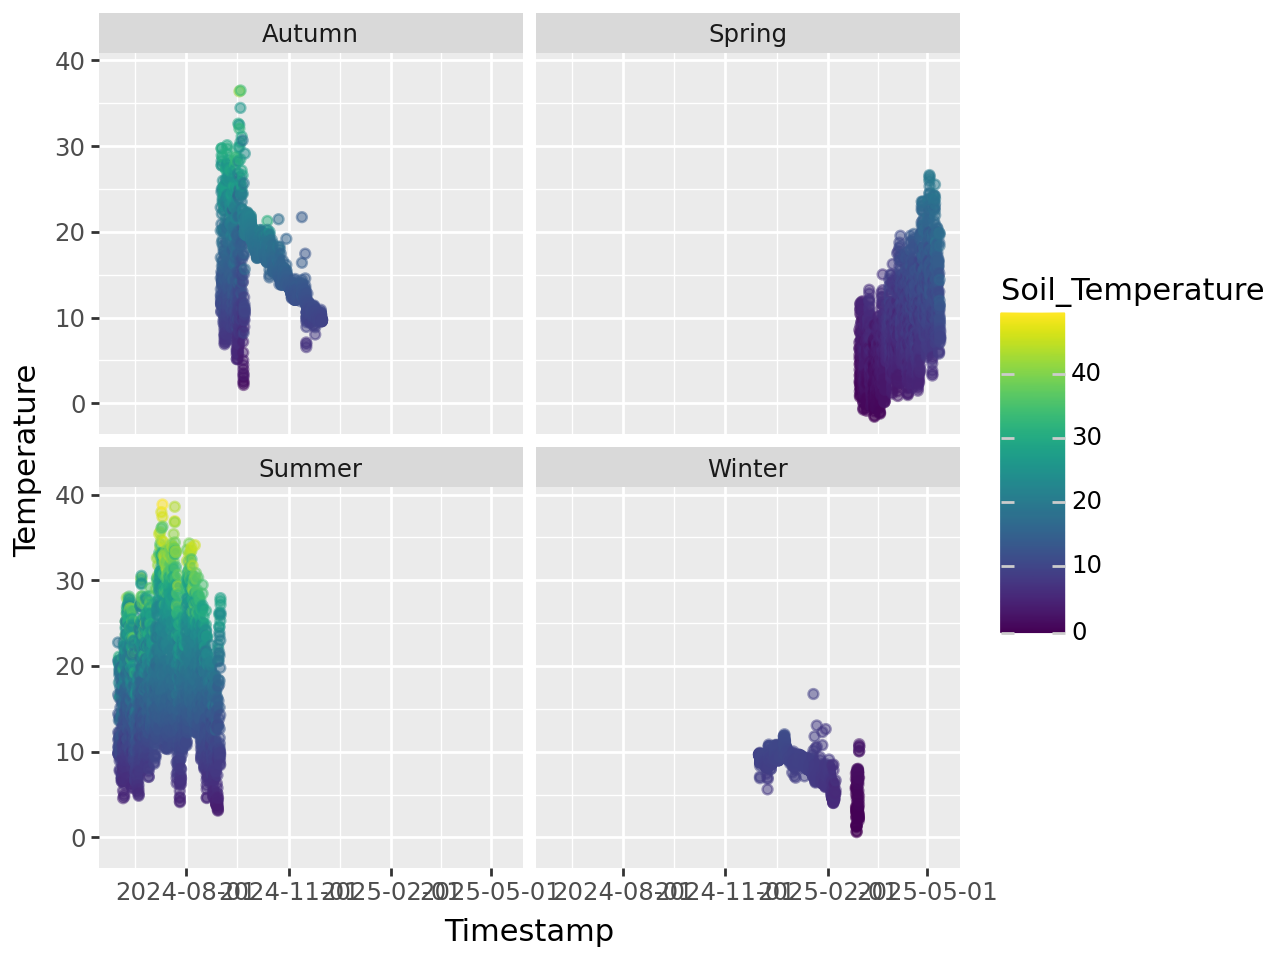

In [13]:
# verificar temperatura
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Temperature', color='Soil_Temperature'), alpha=0.5)
    + facet_wrap('~Season')
)
p.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 451 rows containing missing values.


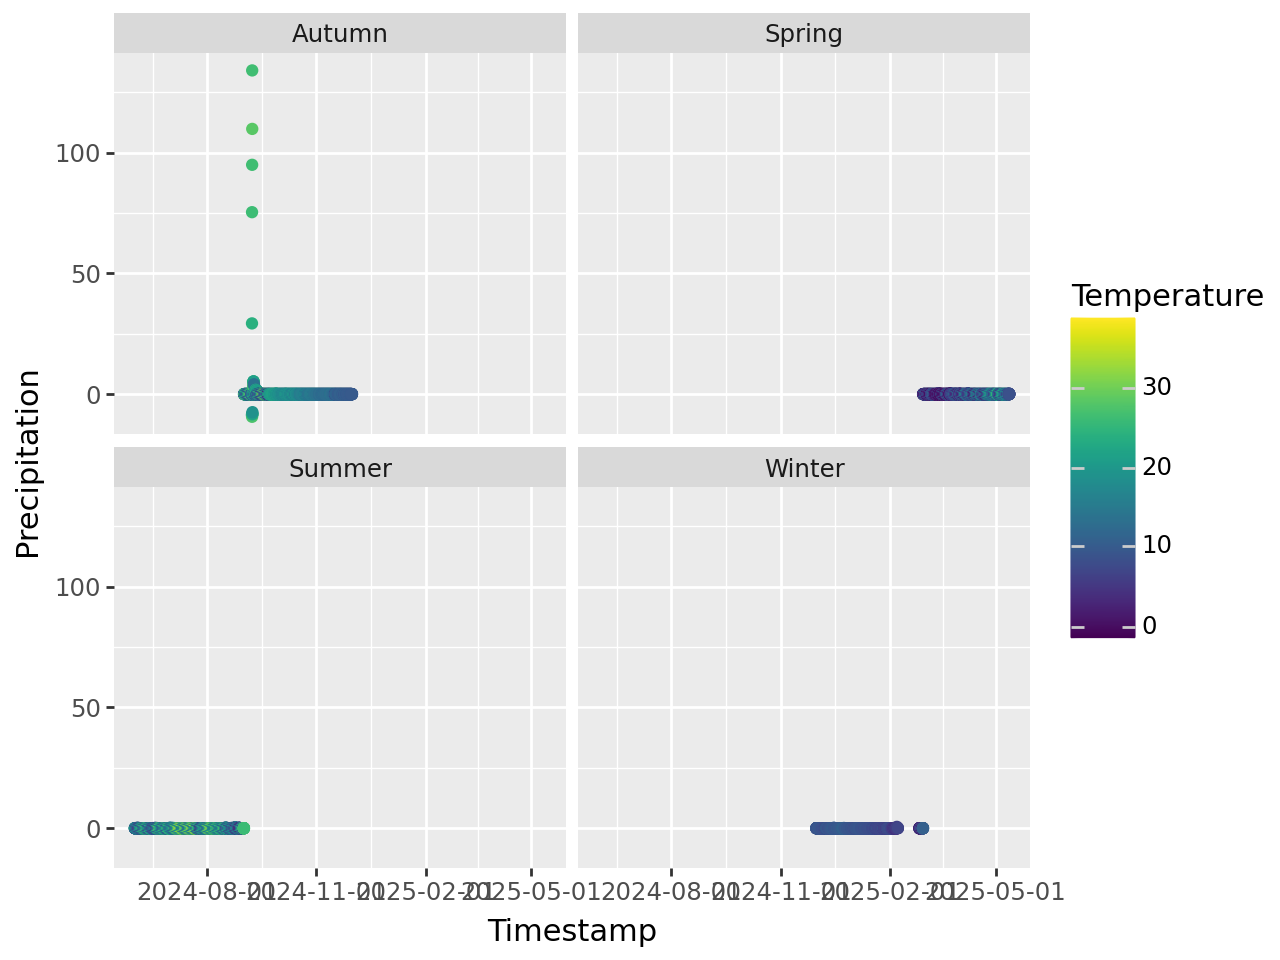

In [14]:
# verificar correlação temperatura e precipitação
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Precipitation', color='Temperature'))
    + facet_wrap('~Season')
)
p.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 451 rows containing missing values.


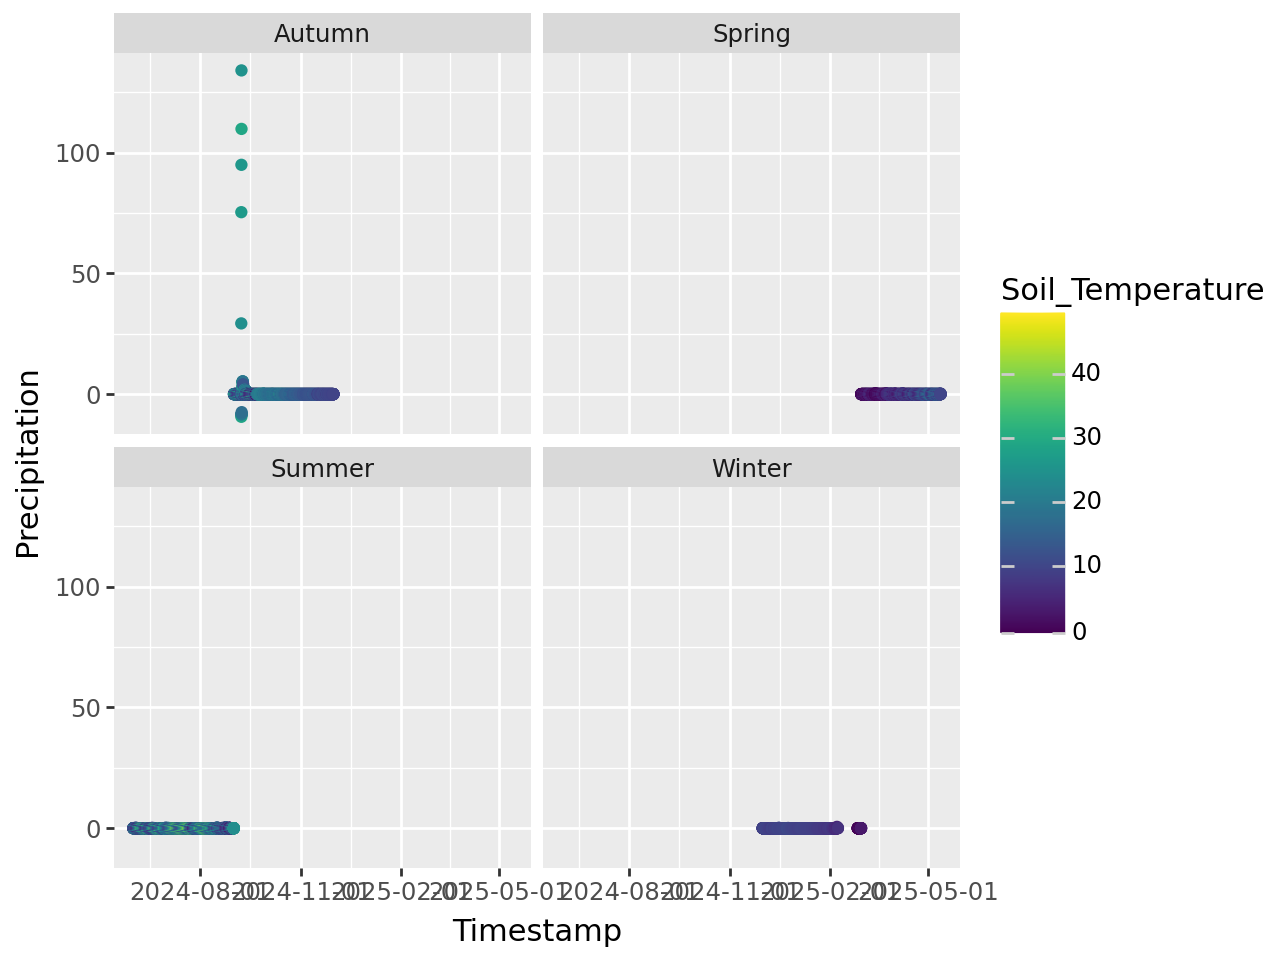

In [15]:
# verificar correlação temperatura do solo e precipitação
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Precipitation', color='Soil_Temperature'))
    + facet_wrap('~Season')
)
p.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 451 rows containing missing values.


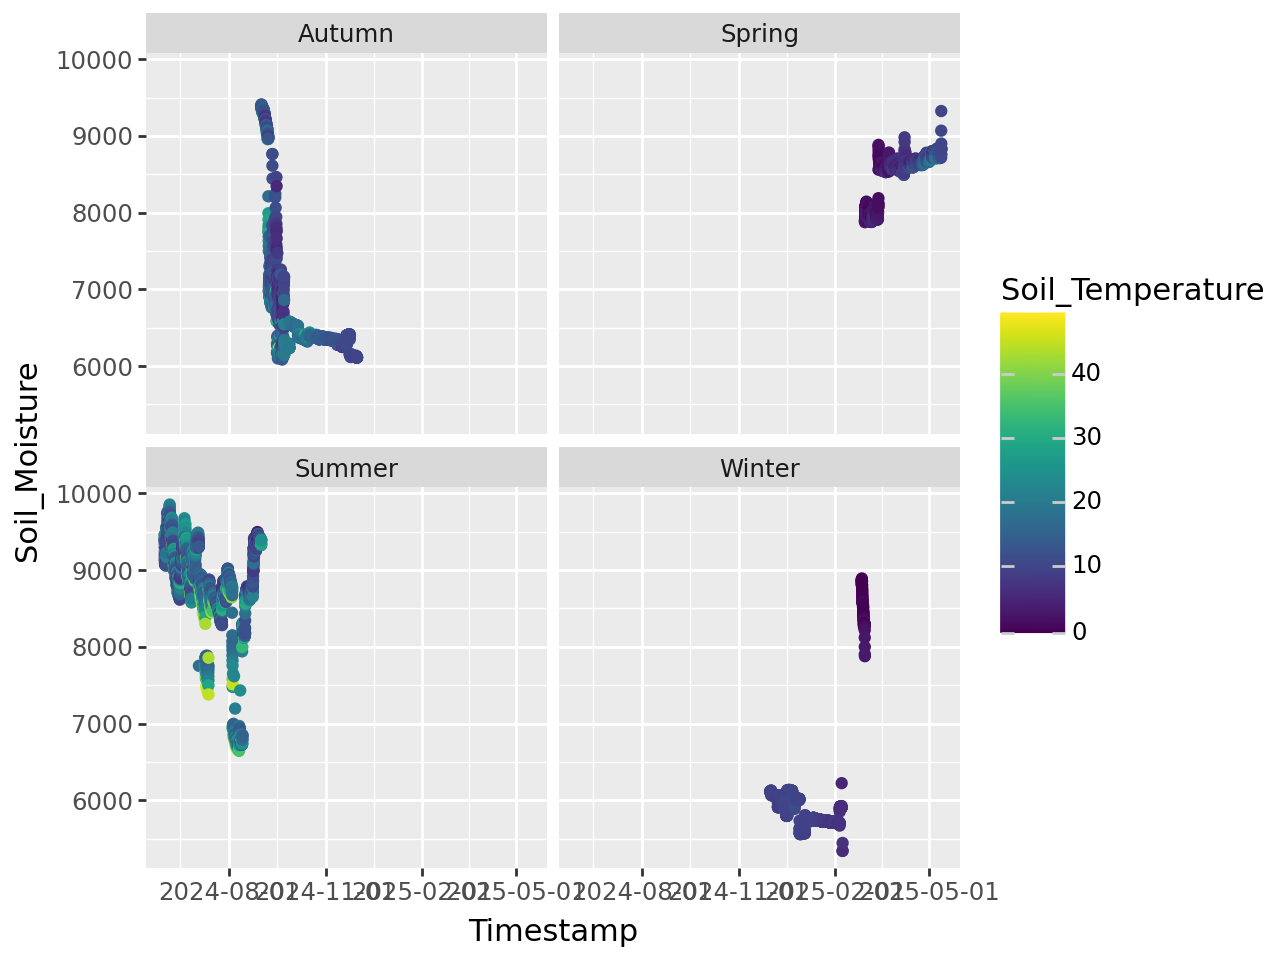

In [16]:
# verificar correlação umidade do solo e temperatura do solo
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Soil_Moisture', color='Soil_Temperature'))
    + facet_wrap('~Season')
)
p.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 451 rows containing missing values.


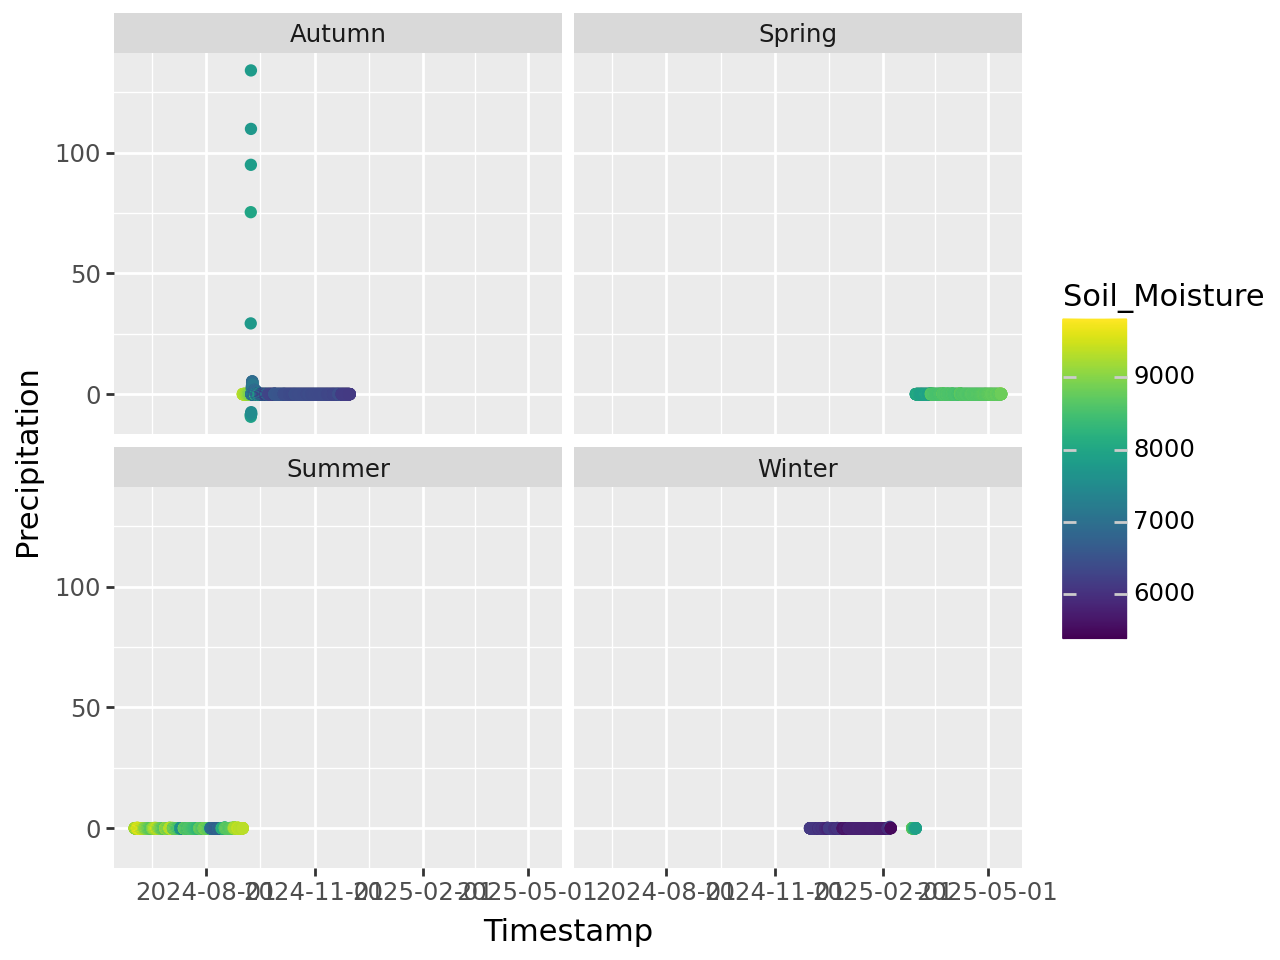

In [17]:
# verificar correlação umidade do solo e precipitação
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Precipitation', color='Soil_Moisture'))
    + facet_wrap('~Season')
)
p.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 451 rows containing missing values.


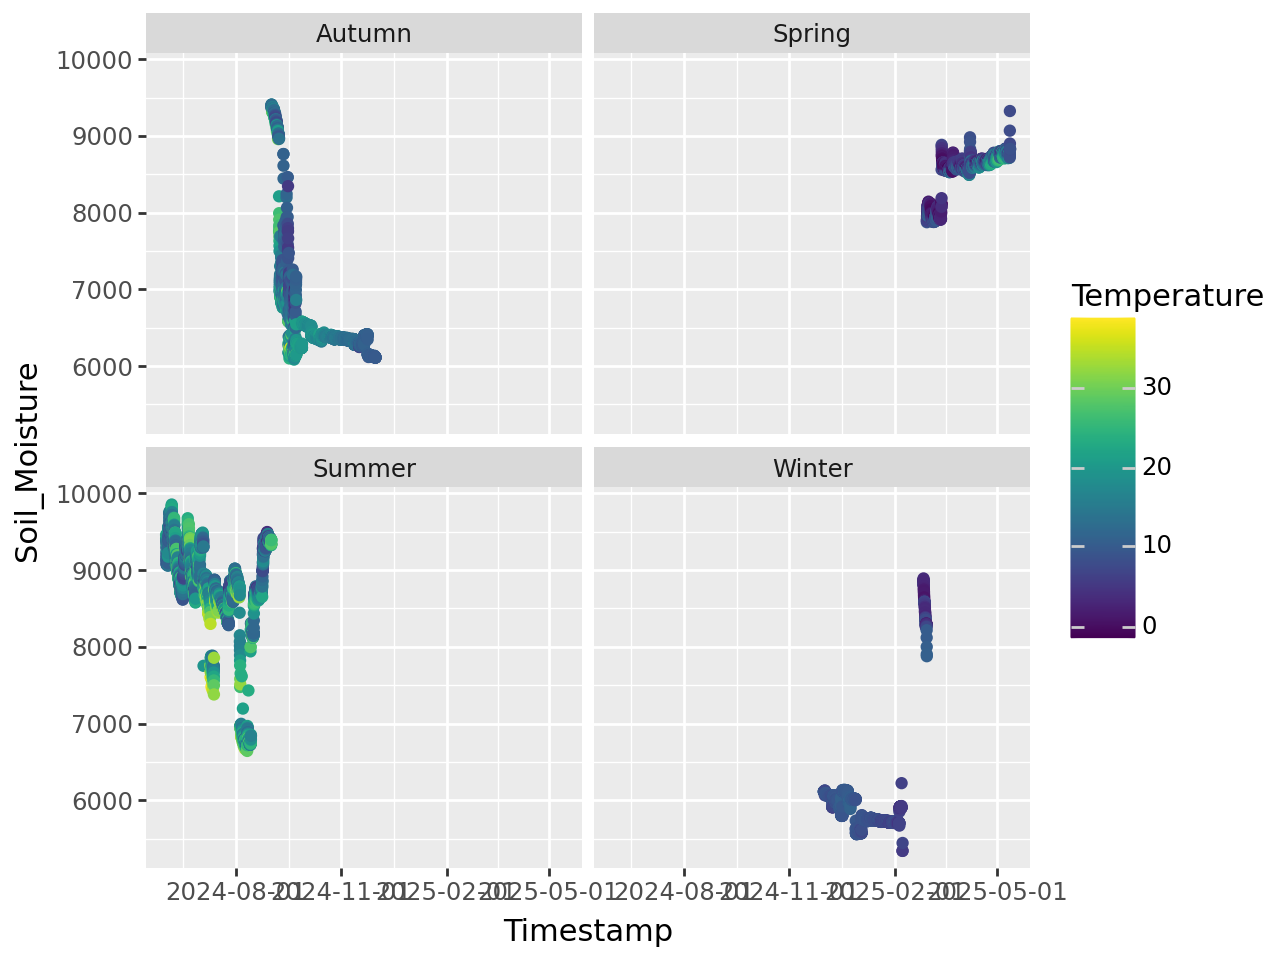

In [18]:
# verificar correlação umidade do solo e temperatura
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Soil_Moisture', color='Temperature'))
    + facet_wrap('~Season')
)
p.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 451 rows containing missing values.


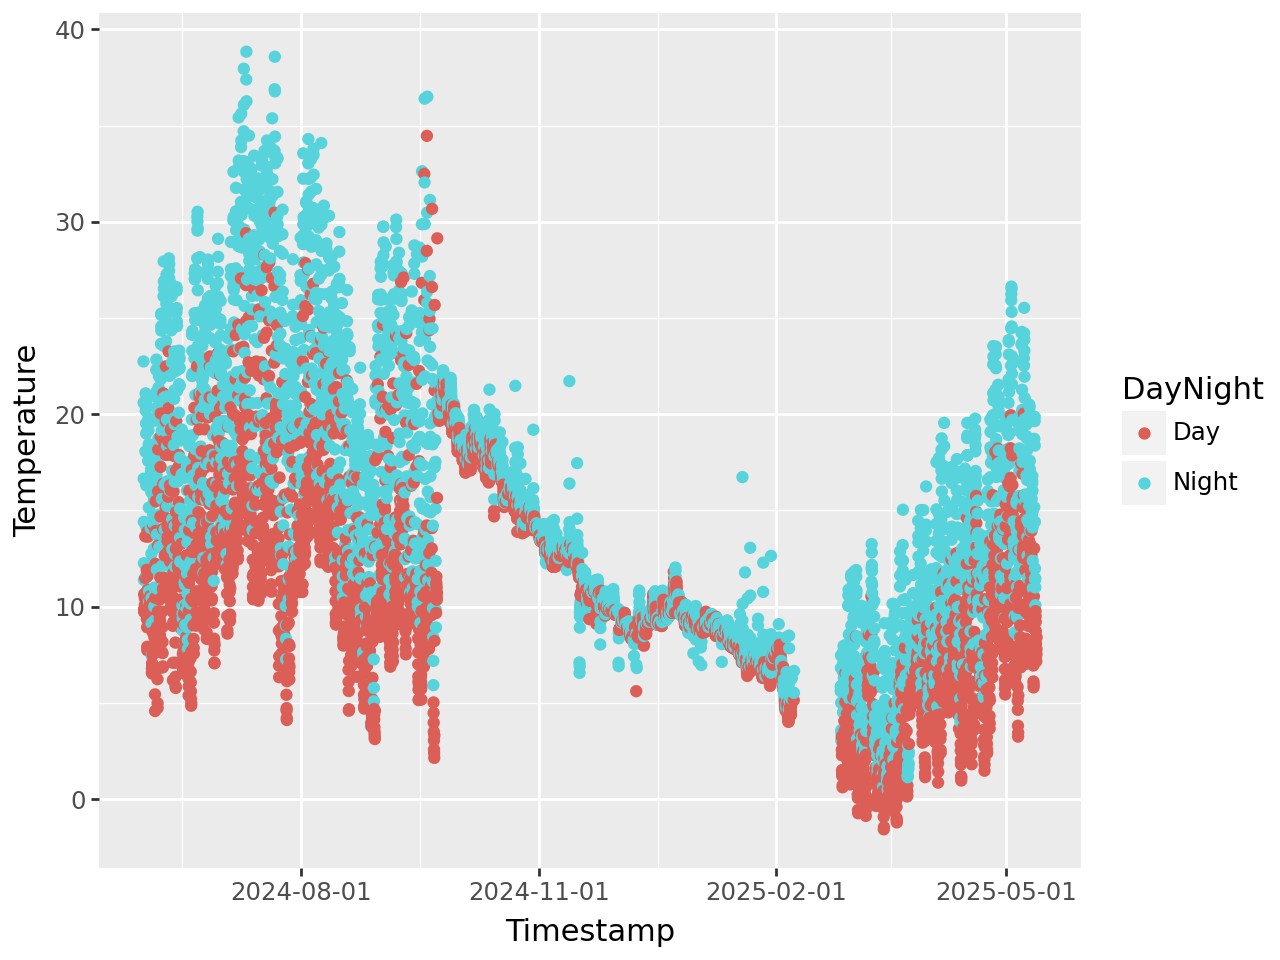

In [19]:
# definir as estações do ano
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Season'] = df['Timestamp'].apply(get_season)

# define se a hora é de dia ou de noite 6h até as 18h é considerado dia o resto é noite
df['Hour'] = df['Timestamp'].dt.hour
df['DayNight'] = df['Hour'].apply(lambda h: 'Day' if 6 <= h < 18 else 'Night')

# verificar temperatura do solo vs temperatura normal de noite e de dia
p = (
    ggplot(df)
    + geom_point(aes(x="Timestamp", y="Temperature", color='DayNight'))
)
p.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 451 rows containing missing values.


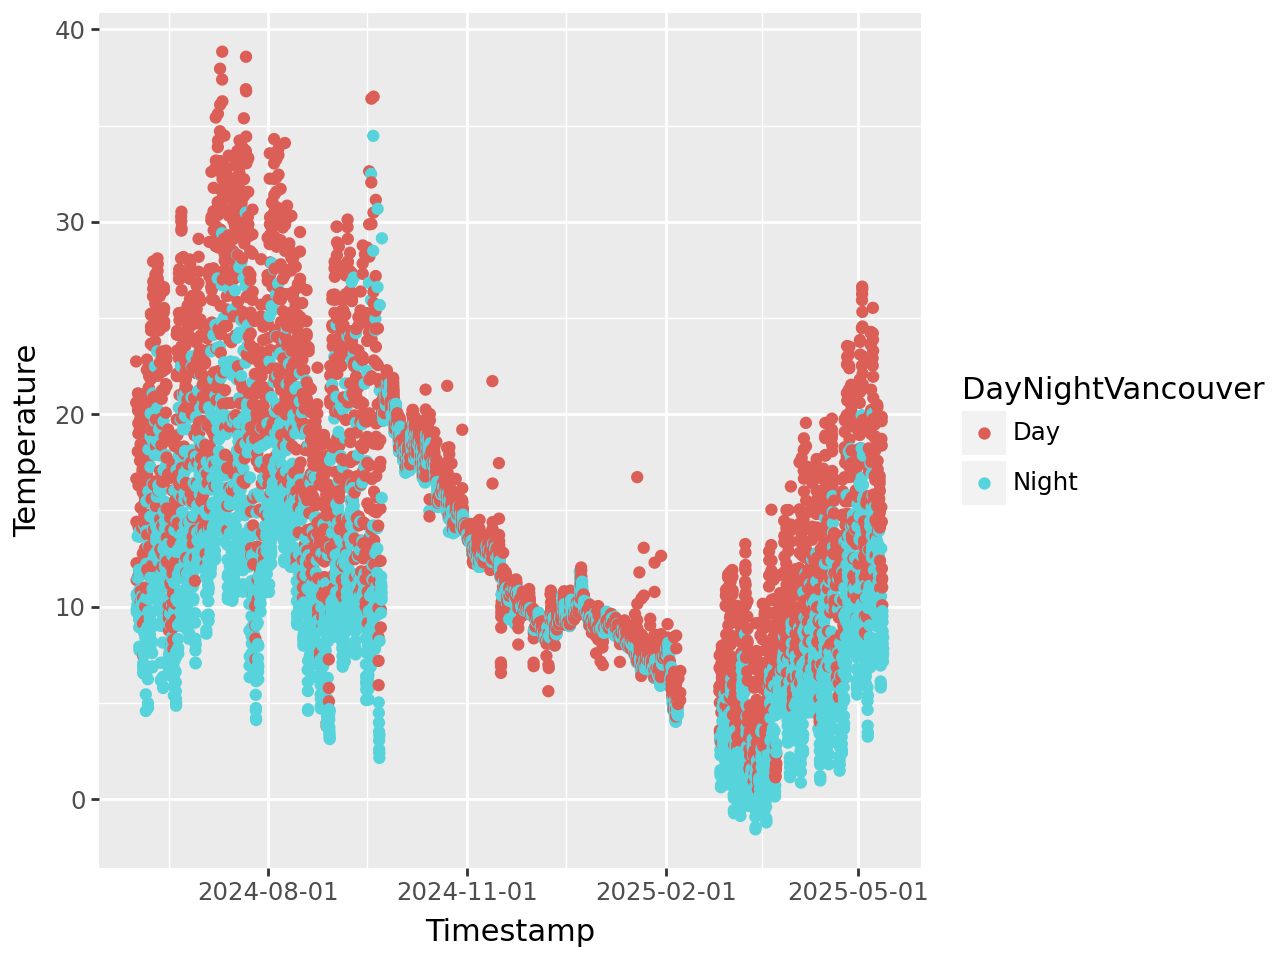

In [40]:
# para testar se os dados estão com outra zona temporal
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True)
df['TimestampVancouver'] = df['Timestamp'].dt.tz_convert('Pacific/Auckland')

df['HourVancouver'] = df['TimestampVancouver'].dt.hour
df['DayNightVancouver'] = df['HourVancouver'].apply(lambda h: 'Day' if 6 <= h < 18 else 'Night')

# verificando se a diferença é por causa da timezone
p = (
    ggplot(df)
    + geom_point(aes(x="Timestamp", y="Temperature", color='DayNightVancouver'))
)
p.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 451 rows containing non-finite values.


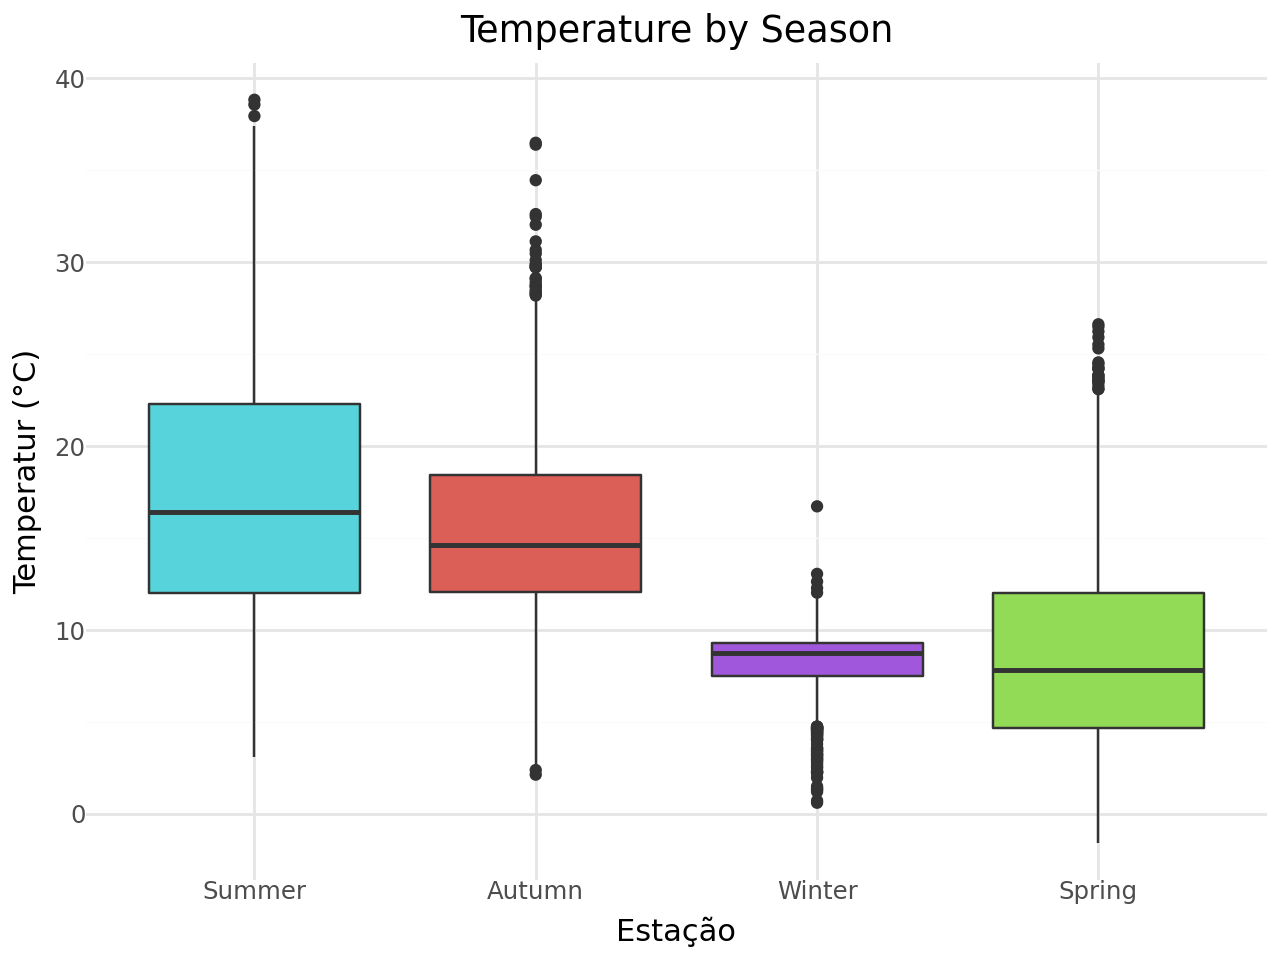

In [41]:
season_order = df['Season'].astype(str).drop_duplicates().tolist()

plot = (
    ggplot(df, aes(x='Season', y='Temperature', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Temperature by Season',
        x='Estação',
        y='Temperatur (°C)'
    )
)
plot.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 451 rows containing non-finite values.


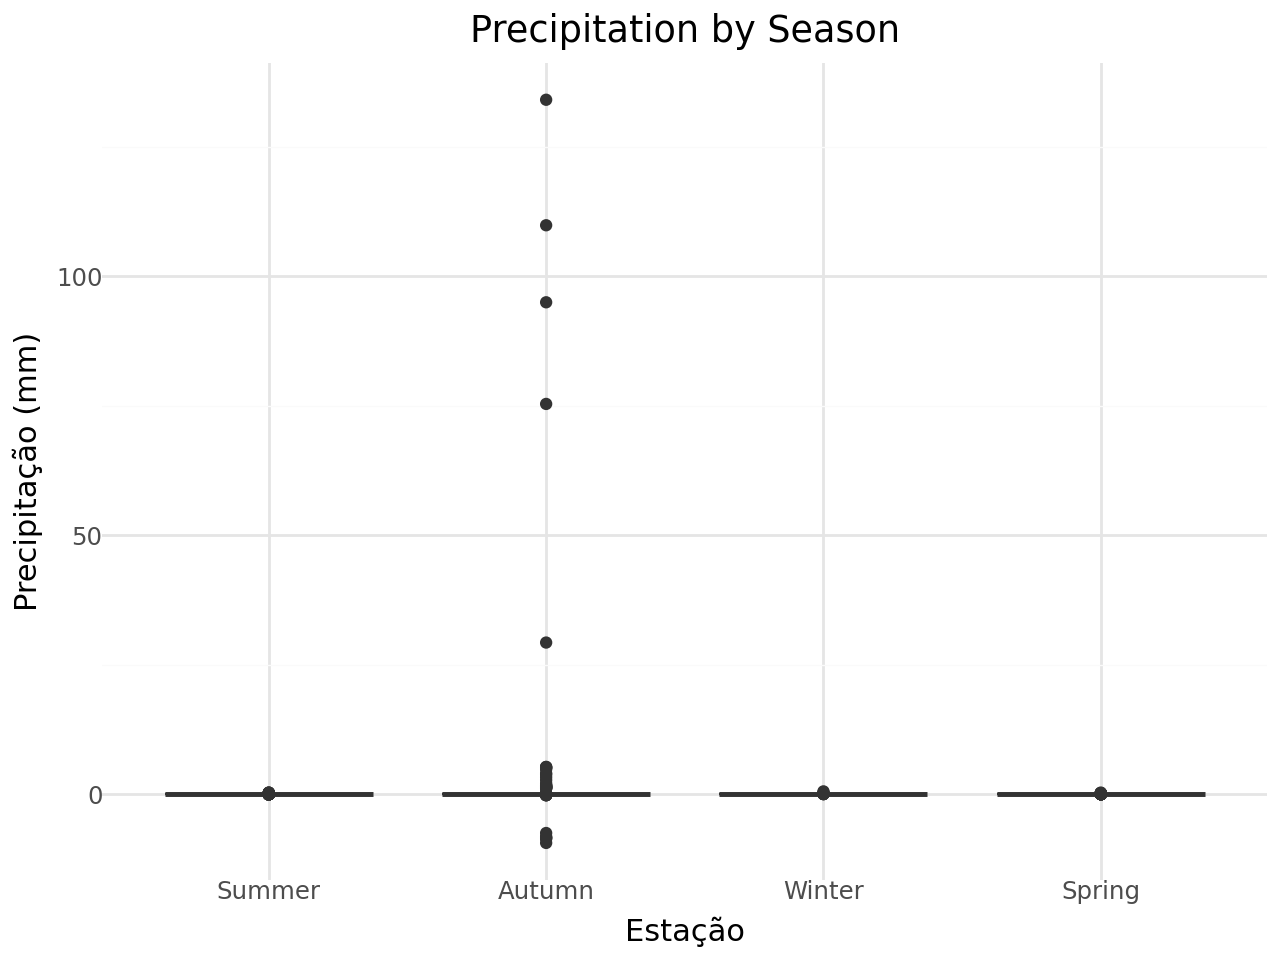

In [42]:
plot = (
    ggplot(df, aes(x='Season', y='Precipitation', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Precipitation by Season',
        x='Estação',
        y='Precipitação (mm)'
    )
)
plot.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 451 rows containing non-finite values.


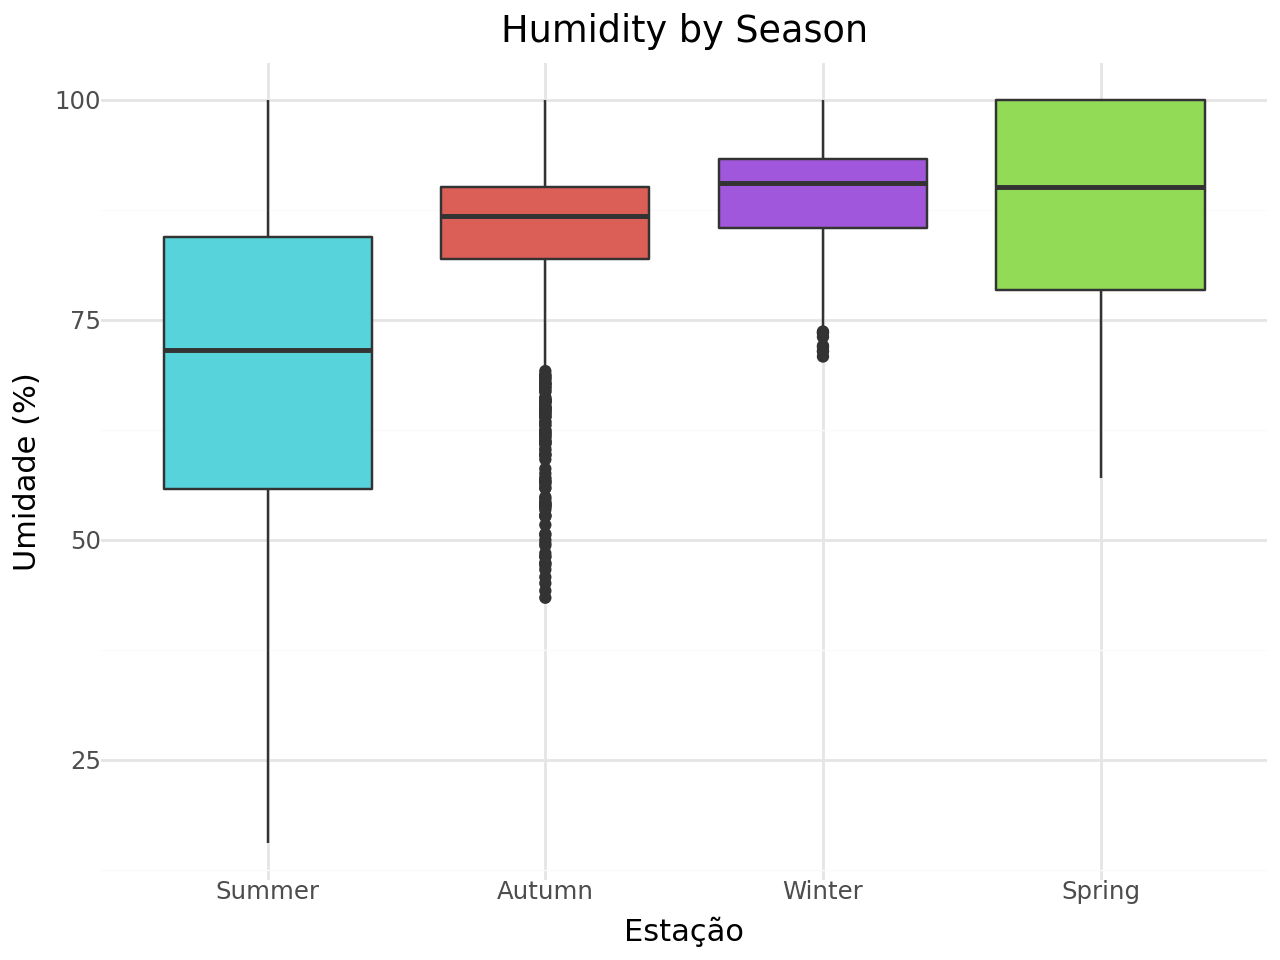

In [43]:
plot = (
    ggplot(df, aes(x='Season', y='Humidity', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Humidity by Season',
        x='Estação',
        y='Umidade (%)'
    )
)
plot.show()

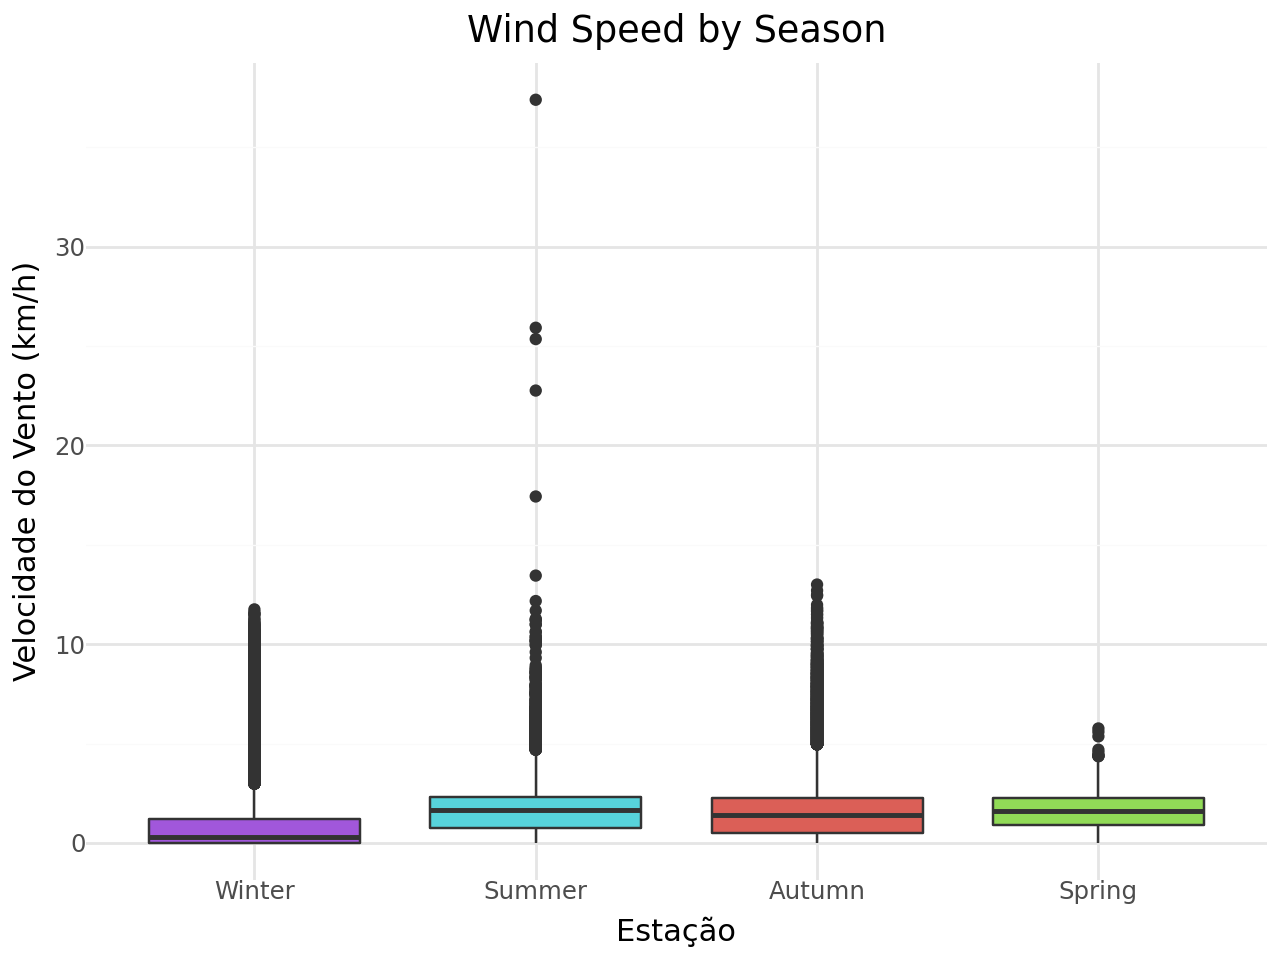

In [36]:
plot = (
    ggplot(df, aes(x='Season', y='Wind_Speed_kmh', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Wind Speed by Season',
        x='Estação',
        y='Velocidade do Vento (km/h)'
    )
)
plot.show()

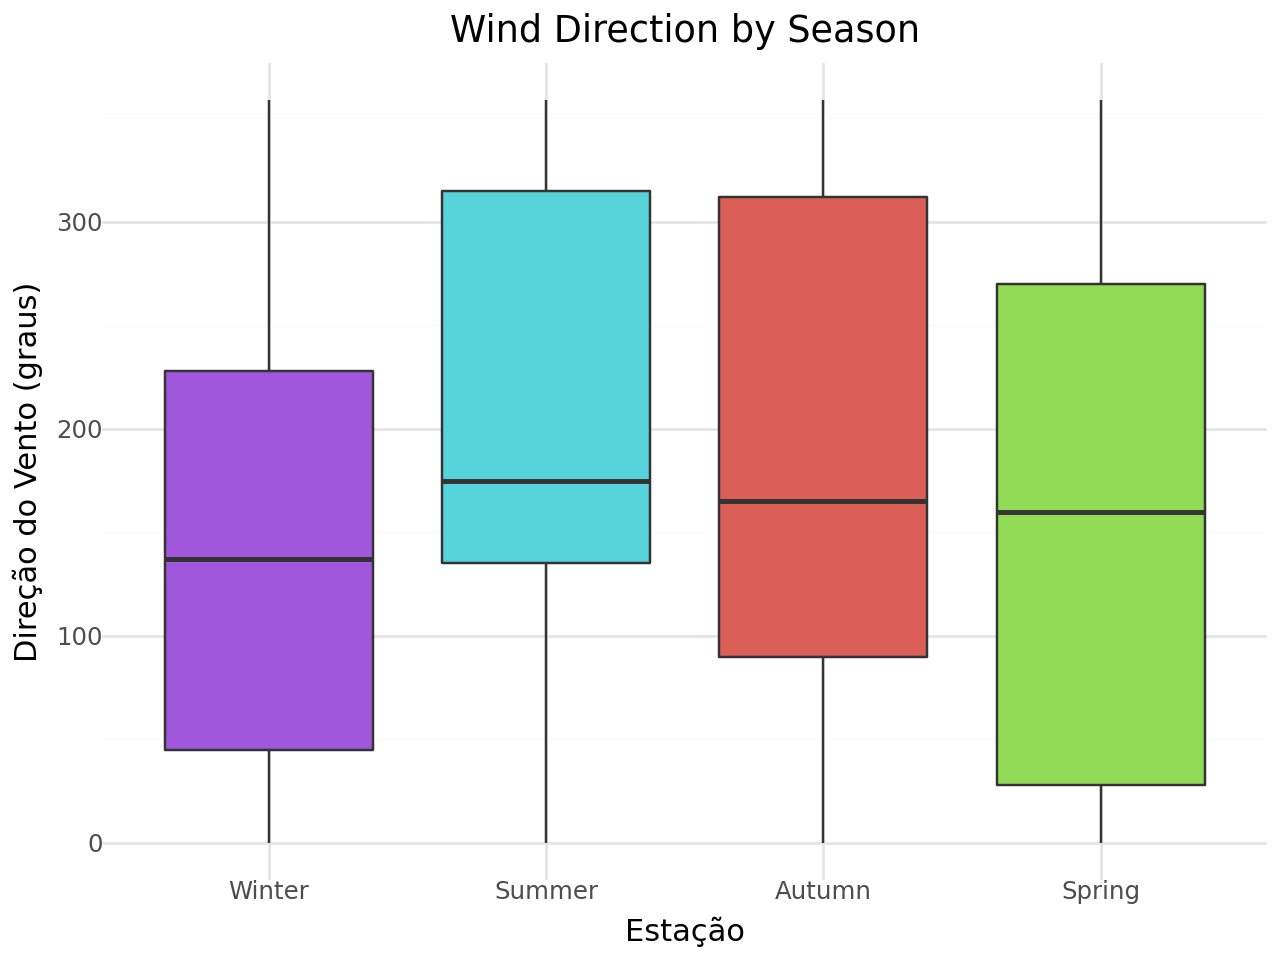

In [37]:
plot = (
    ggplot(df, aes(x='Season', y='Wind_Direction', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Wind Direction by Season',
        x='Estação',
        y='Direção do Vento (graus)'
    )
)
plot.show()

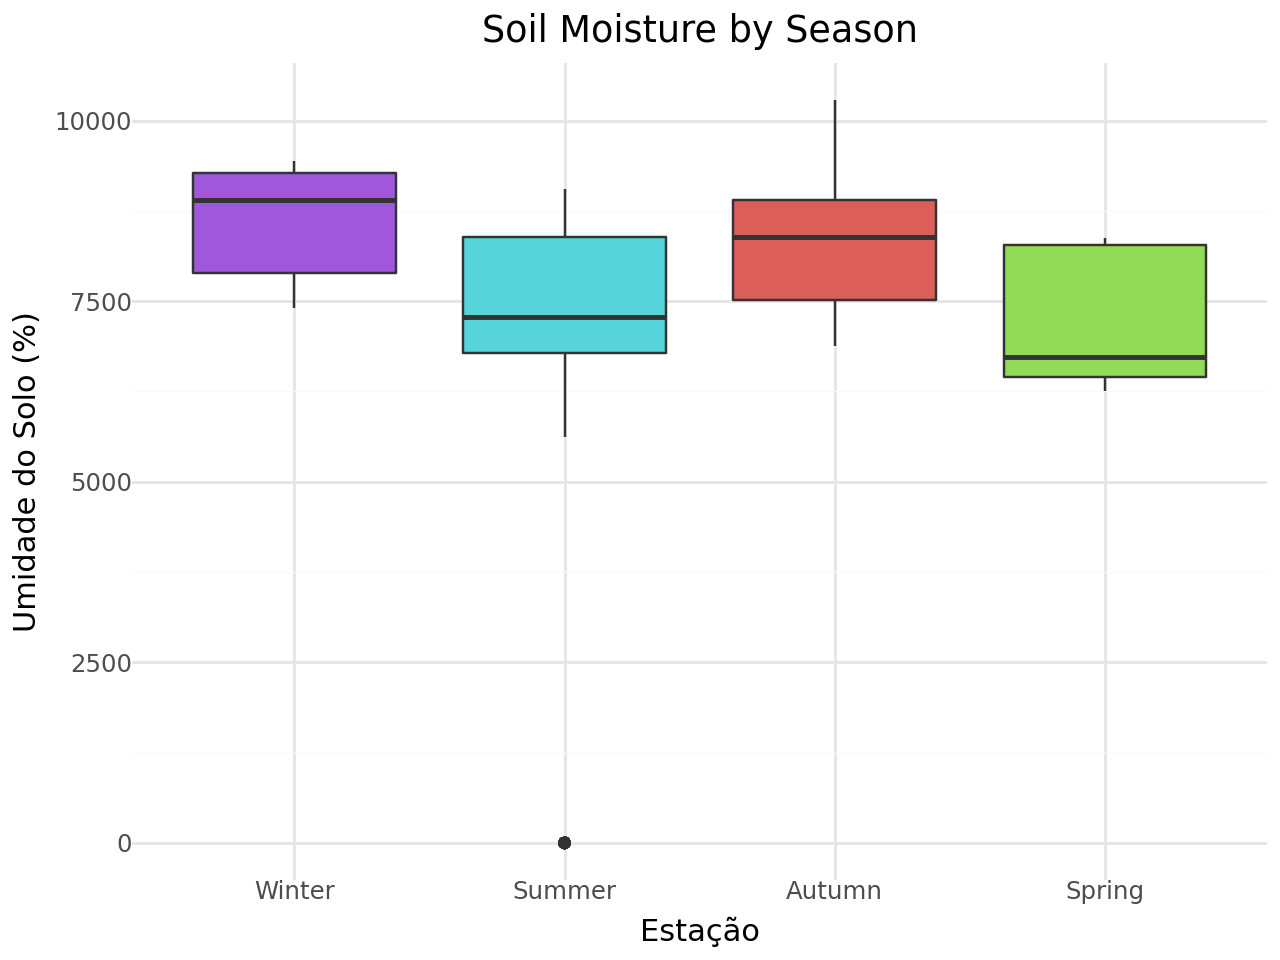

In [38]:
plot = (
    ggplot(df, aes(x='Season', y='Soil_Moisture', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Soil Moisture by Season',
        x='Estação',
        y='Umidade do Solo (%)'
    )
)
plot.show()

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 5699 rows containing non-finite values.


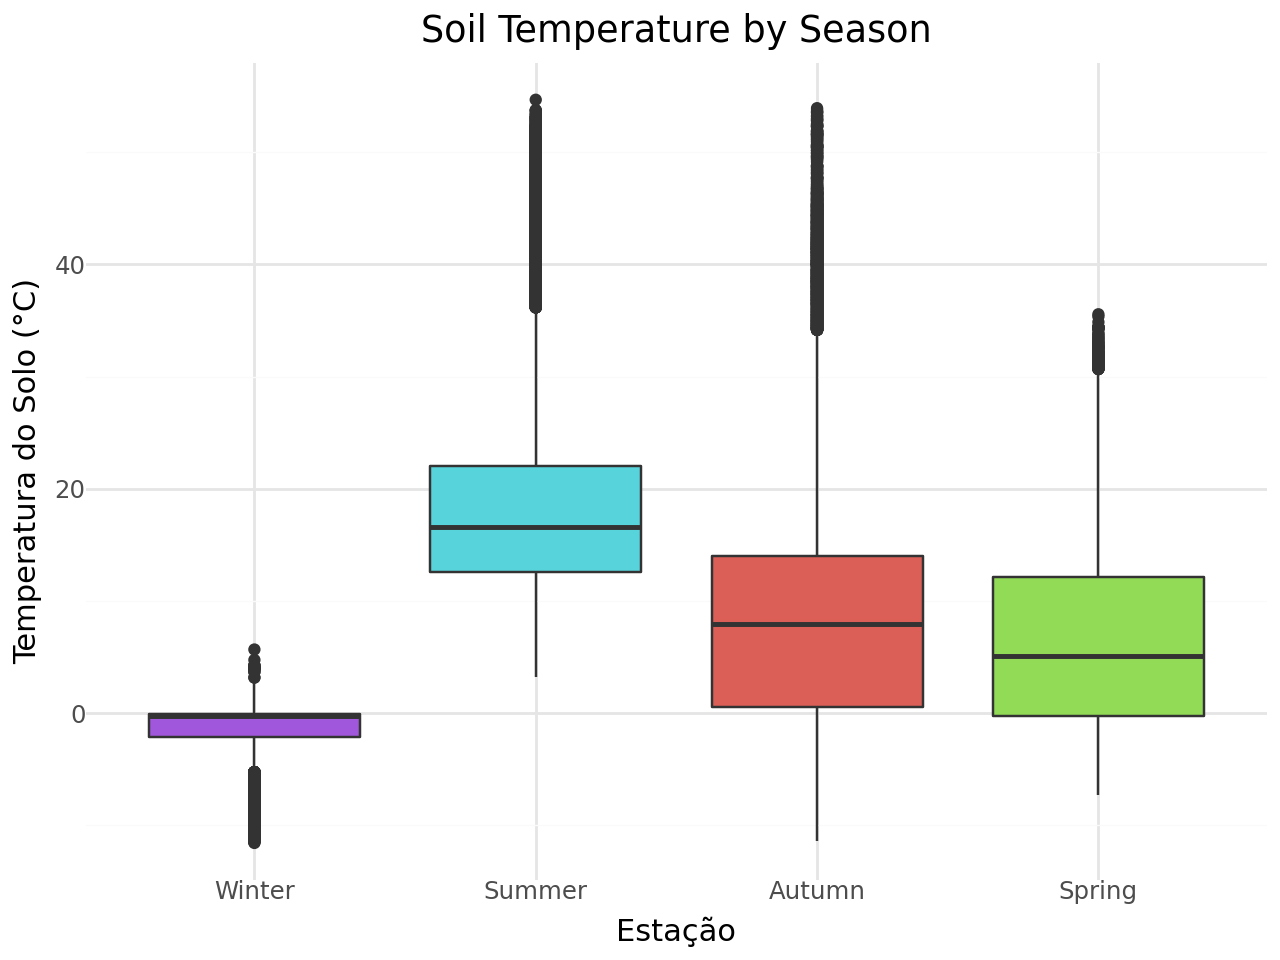

In [39]:
plot = (
    ggplot(df, aes(x='Season', y='Soil_Temperature', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Soil Temperature by Season',
        x='Estação',
        y='Temperatura do Solo (°C)'
    )
)
plot.show()